# YOLOv8 Oriented Bounding Boxes Object Detection with OpenVINO™

[YOLOv8-OBB](https://docs.ultralytics.com/tasks/obb/) is introduced by Ultralytics.

Oriented object detection goes a step further than object detection and introduce an extra angle to locate objects more accurate in an image.

The output of an oriented object detector is a set of rotated bounding boxes that exactly enclose the objects in the image, along with class labels and confidence scores for each box. Object detection is a good choice when you need to identify objects of interest in a scene, but don't need to know exactly where the object is or its exact shape.

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Get PyTorch model](#Get-PyTorch-model)
- [Prepare dataset and dataloader](#Prepare-dataset-and-dataloader)
- [Run inference](#Run-inference)
- [Convert PyTorch model to OpenVINO IR](#Convert-PyTorch-model-to-OpenVINO-IR)
  - [Select inference device](#Select-inference-device)
  - [Compile model](#Compile-model)
  - [Prepare the model for inference](#Prepare-the-model-for-inference)
  - [Run inference](#Run-inference)
- [Quantization](#Quantization)
- [Compare inference time and model sizes.](#Compare-inference-time-and-model-sizes)

### Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
%pip install -q "ultralytics==8.2.24" "openvino>=2024.0.0" "nncf>=2.9.0" tqdm

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


Import required utility functions. The lower cell will download the notebook_utils Python module from GitHub.

In [1]:
from pathlib import Path

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file

### Get PyTorch model
[back to top ⬆️](#Table-of-contents:)

Generally, PyTorch models represent an instance of the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the YOLOv8 pretrained OBB large model (also known as `yolov8l-obbn`) pre-trained on a DOTAv1 dataset, which is available in this [repo](https://github.com/ultralytics/ultralytics). Similar steps are also applicable to other YOLOv8 models.

In [2]:
from ultralytics import YOLO

model = YOLO(r"bicycle_weights\best.pt")

### Prepare dataset and dataloader
[back to top ⬆️](#Table-of-contents:)

YOLOv8-obb is pre-trained on the DOTA dataset. Also, Ultralytics provides DOTA8 dataset. It is a small, but versatile oriented object detection dataset composed of the first 8 images of 8 images of the split DOTAv1 set, 4 for training and 4 for validation. This dataset is ideal for testing and debugging object detection models, or for experimenting with new detection approaches. With 8 images, it is small enough to be easily manageable, yet diverse enough to test training pipelines for errors and act as a sanity check before training larger datasets.

The original model repository uses a Validator wrapper, which represents the accuracy validation pipeline. It creates dataloader and evaluation metrics and updates metrics on each data batch produced by the dataloader. Besides that, it is responsible for data preprocessing and results postprocessing. For class initialization, the configuration should be provided. We will use the default setup, but it can be replaced with some parameters overriding to test on custom data. The model has connected the task_map, which allows to get a validator class instance.

### Run inference
[back to top ⬆️](#Table-of-contents:)

image 1/1 E:\Helmet-Compliance-Detection-System\test_image_1.jpg: 384x640 7 motorbikes, 151.1ms
Speed: 2.5ms preprocess, 151.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


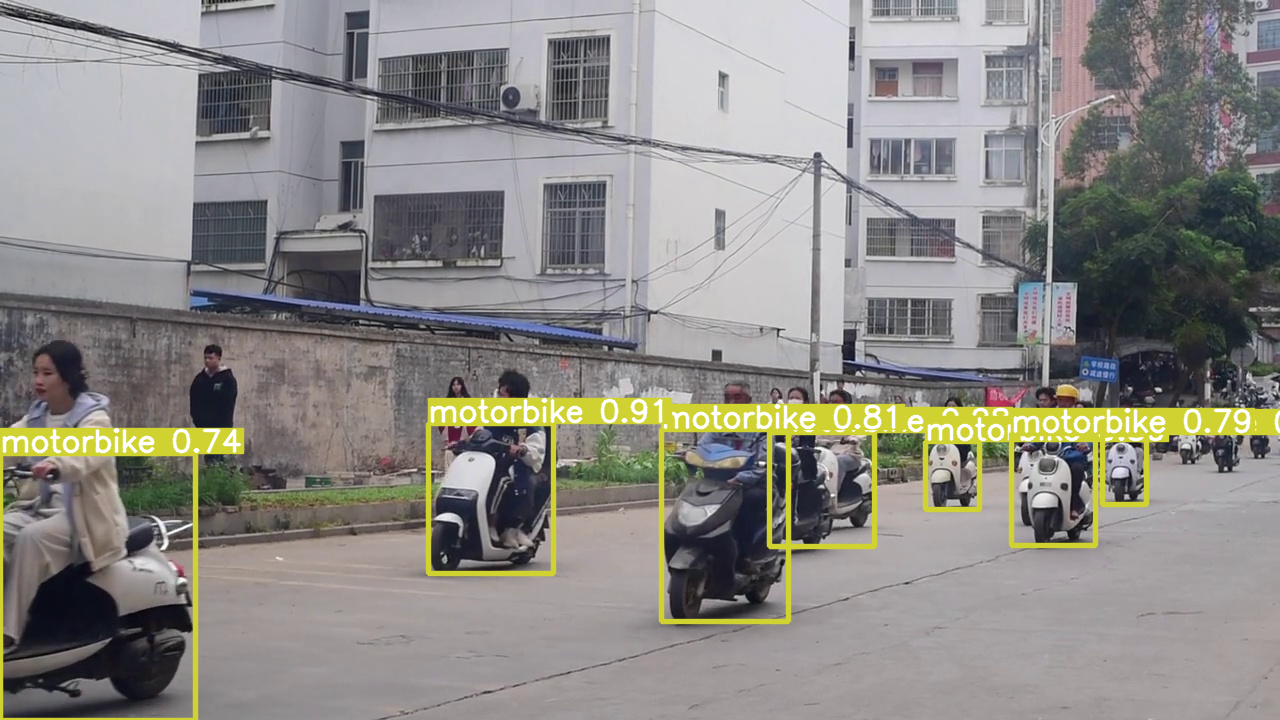

In [3]:
from PIL import Image
example_image_path = r"test_image_1.jpg"
res = model(example_image_path, device="cpu")
Image.fromarray(res[0].plot()[:, :, ::-1])

### Convert PyTorch model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

YOLOv8 provides API for convenient model exporting to different formats including OpenVINO IR. `model.export` is responsible for model conversion. We need to specify the format, and additionally, we can preserve dynamic shapes in the model.

In [4]:
from pathlib import Path

# models_dir = Path("./models")
# models_dir.mkdir(exist_ok=True)
# 
# 
# OV_MODEL_NAME = "yolov8l-obb"


OV_MODEL_PATH = Path(f"bicycle_weights/best_openvino_model/best.xml")
# if not OV_MODEL_PATH.exists():
#     model.export(format="openvino", dynamic=True, half=True)

#### Select inference device
[back to top ⬆️](#Table-of-contents:)

Select device from dropdown list for running inference using OpenVINO

In [5]:
import ipywidgets as widgets
import openvino as ov

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

#### Compile model
[back to top ⬆️](#Table-of-contents:)

In [6]:
ov_model = core.read_model(OV_MODEL_PATH)

ov_config = {}
if device.value != "CPU":
    ov_model.reshape({0: [1, 3, 1024, 1024]})
if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}

compiled_ov_model = core.compile_model(ov_model, device.value, ov_config)

#### Prepare the model for inference
[back to top ⬆️](#Table-of-contents:)

We can reuse the base model pipeline for pre- and postprocessing just replacing the inference method where we will use the IR model for inference.

In [7]:
import torch


def infer(*args):
    result = compiled_ov_model(args)[0]
    return torch.from_numpy(result)


model.predictor.inference = infer

#### Run inference
[back to top ⬆️](#Table-of-contents:)

image 1/1 E:\Helmet-Compliance-Detection-System\test_image_1.jpg: 384x640 7 motorbikes, 98.6ms
Speed: 1.0ms preprocess, 98.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


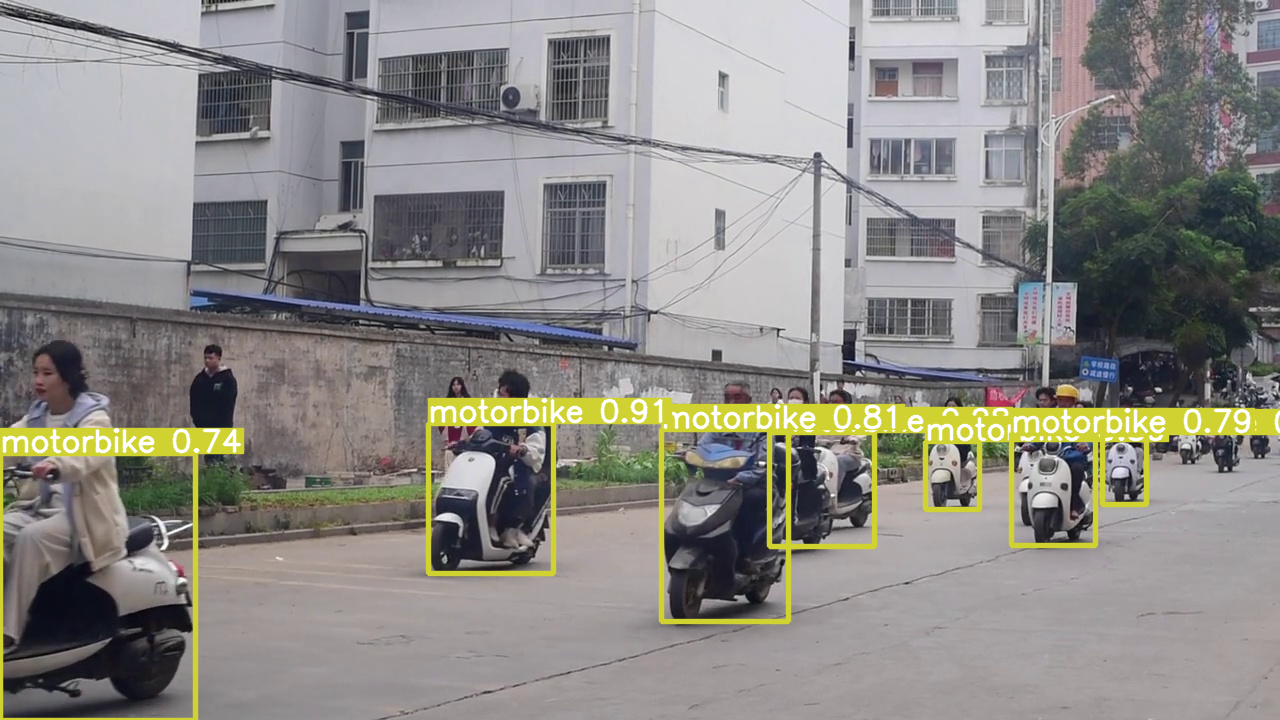

In [8]:
res = model(example_image_path, device="cpu")
Image.fromarray(res[0].plot()[:, :, ::-1])

In [10]:
print(res[0].boxes)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([4., 4., 4., 4., 4., 4., 4.])
conf: tensor([0.9051, 0.8131, 0.7861, 0.7365, 0.5916, 0.3858, 0.2822])
data: tensor([[4.2803e+02, 4.2306e+02, 5.5306e+02, 5.7350e+02, 9.0508e-01, 4.0000e+00],
        [6.6192e+02, 4.2966e+02, 7.8853e+02, 6.2145e+02, 8.1307e-01, 4.0000e+00],
        [1.0113e+03, 4.3398e+02, 1.0951e+03, 5.4576e+02, 7.8611e-01, 4.0000e+00],
        [0.0000e+00, 4.5307e+02, 1.9593e+02, 7.2000e+02, 7.3650e-01, 4.0000e+00],
        [1.1030e+03, 4.3462e+02, 1.1461e+03, 5.0438e+02, 5.9163e-01, 4.0000e+00],
        [9.2572e+02, 4.4168e+02, 9.7932e+02, 5.0920e+02, 3.8575e-01, 4.0000e+00],
        [7.6961e+02, 4.3274e+02, 8.7461e+02, 5.4616e+02, 2.8220e-01, 4.0000e+00]])
id: None
is_track: False
orig_shape: (720, 1280)
shape: torch.Size([7, 6])
xywh: tensor([[ 490.5438,  498.2811,  125.0259,  150.4430],
        [ 725.2209,  525.5580,  126.6088,  191.7883],
        [1053.1799,  489.8712,   83.7836,  111.7819],
     

### Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized model.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [11]:
import ipywidgets as widgets

INT8_OV_PATH = Path("model/int8_model.xml")

to_quantize = widgets.Checkbox(
    value=True,
    description="Quantization",
    disabled=False,
)

to_quantize

Checkbox(value=True, description='Quantization')

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [12]:
# Fetch skip_kernel_extension module
r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

In [13]:
%%skip not $to_quantize.value

from typing import Dict

import nncf


def transform_fn(data_item: Dict):
    input_tensor = validator.preprocess(data_item)["img"].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(data_loader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


Create a quantized model from the pre-trained converted OpenVINO model.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

> **NOTE**: We use the tiny DOTA8 dataset as a calibration dataset. It gives a good enough result for tutorial purpose. For batter results, use a bigger dataset. Usually 300 examples are enough.

In [14]:
%%skip not $to_quantize.value

if INT8_OV_PATH.exists():
    print("Loading quantized model")
    quantized_model = core.read_model(INT8_OV_PATH)
else:
    ov_model.reshape({0: [1, 3, -1, -1]})
    quantized_model = nncf.quantize(
        ov_model,
        quantization_dataset,
        preset=nncf.QuantizationPreset.MIXED,
    )
    ov.save_model(quantized_model, INT8_OV_PATH)


ov_config = {}
if device.value != "CPU":
    quantized_model.reshape({0: [1, 3, 1024, 1024]})
if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}

model_optimized = core.compile_model(quantized_model, device.value, ov_config)

Output()

Output()

We can reuse the base model pipeline in the same way as for IR model.

In [15]:
%%skip not $to_quantize.value

def infer(*args):
    result = model_optimized(args)[0]
    return torch.from_numpy(result)

model.predictor.inference = infer

Run inference

In [16]:
%%skip not $to_quantize.value

res = model(example_image_path, device='cpu')
Image.fromarray(res[0].plot()[:, :, ::-1])


image 1/1 /home/ea/work/openvino_notebooks/notebooks/fast-segment-anything/datasets/dota8/images/train/P1053__1024__0___90.jpg: 1024x1024 240.5ms
Speed: 3.2ms preprocess, 240.5ms inference, 4.2ms postprocess per image at shape (1, 3, 1024, 1024)


You can see that the result is almost the same but it has a small difference. One small vehicle was recognized as two vehicles. But one large car was also identified, unlike the original model.

### Compare inference time and model sizes
[back to top ⬆️](#Table-of-contents:)

In [17]:
%%skip not $to_quantize.value

fp16_ir_model_size = OV_MODEL_PATH.with_suffix(".bin").stat().st_size / 1024
quantized_model_size = INT8_OV_PATH.with_suffix(".bin").stat().st_size / 1024

print(f"FP16 model size: {fp16_ir_model_size:.2f} KB")
print(f"INT8 model size: {quantized_model_size:.2f} KB")
print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 model size: 86849.05 KB
INT8 model size: 43494.78 KB
Model compression rate: 1.997


In [18]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m $OV_MODEL_PATH -d $device.value -api async -shape "[1,3,640,640]"

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ WARNING ] Default duration 120 seconds is used for unknown device AUTO
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.0.0-14509-34caeefd078-releases/2024/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.0.0-14509-34caeefd078-releases/2024/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 25.07 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.22/aten::cat/Concat_9) : f32 / [...] / [?,20,16..]
[Step 5/11] Re

In [19]:
if INT8_OV_PATH.exists():
    # Inference INT8 model (Quantized model)
    !benchmark_app -m $INT8_OV_PATH -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.0.0-14509-34caeefd078-releases/2024/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.0.0-14509-34caeefd078-releases/2024/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 46.47 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.22/aten::cat/Concat_9) : f32 / [...] / [?,20,16..]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch si